# BASICS 02 - One layer of HOTS in PyTorch

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import tonic, torch
from utils import timesurface, get_loader, get_dataset_info
import matplotlib.pyplot as plt
from tqdm import tqdm

print(f' Tonic version installed -> {tonic.__version__}')

 Tonic version installed -> 1.0.15


In [5]:
transform = tonic.transforms.NumpyAsType(int)
dataset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=transform)
loader = get_loader(dataset, shuffle=True)
#get_dataset_info(dataset, properties = ['time', 'mean_isi', 'nb_events']);

In [67]:
R = 4
ts_size = (2*R+1)
tau = 5e3#7e2

transform = tonic.transforms.Compose([tonic.transforms.ToTimesurface(sensor_size=dataset.sensor_size, tau=tau, decay='exp', surface_dimensions=(ts_size,ts_size))])
dataset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=transform)
loader = get_loader(dataset, shuffle=True, batch_size=None, kfold=600)

In [69]:
class hotslayer(torch.nn.Module):
    def __init__(self, ts_size, n_neurons, bias=False, homeostasis = True, device="cpu"):
        super(hotslayer, self).__init__()
        self.synapses = torch.nn.Linear(ts_size, n_neurons, bias=bias)
        torch.nn.init.uniform_(self.synapses.weight, a=0, b=1)
        self.cumhisto = torch.ones([n_neurons]).to(device)
        self.learning_flag = True
        self.homeo_flag = homeostasis
        
    def homeo_gain(self):
        lambda_homeo = .25
        gain = torch.exp(lambda_homeo*(1-self.cumhisto.size(dim=0)*self.cumhisto/self.cumhisto.sum()))
        return gain

    def forward(self, all_ts):
        if self.learning_flag:
            for iev in range(len(all_ts)):
                ts = all_ts[iev].ravel()
                ts = ts/torch.linalg.norm(ts)
                beta = self.synapses(ts)/(torch.linalg.norm(self.synapses.weight.data, dim=1))
                if self.homeo_flag:
                    beta_homeo = self.homeo_gain()*(self.synapses(ts)/(torch.linalg.norm(self.synapses.weight.data, dim=1)))
                    n_star = torch.argmax(beta_homeo)
                else:
                    n_star = torch.argmax(beta)

                Ck = self.synapses.weight.data[n_star,:]
                alpha = 0.01/(1+self.cumhisto[n_star]/20000)
                self.synapses.weight.data[n_star,:] = Ck + alpha*beta[n_star]*(ts - Ck)
                #self.synapses.weight.data[n_star,:] /= torch.linalg.norm(self.synapses.weight.data[n_star,:])
                # learning rule from Lagorce 2017
                #self.synapses[:,n_star] = Ck + alpha*(TS - simil[closest_proto_idx]*Ck)
                self.cumhisto[n_star] += 1
        else:
            all_ts = torch.flatten(all_ts, start_dim=1, end_dim=- 1)
            all_ts = all_ts/torch.linalg.norm(all_ts, dim=0)
            beta = self.synapses(all_ts)/(torch.linalg.norm(self.synapses.weight.data, dim=1))
            n_star = torch.argmax(beta, dim=1)
        return n_star

In [70]:
R = 4
n_pola = 2
ts_size = (2*R+1)**2*n_pola
n_neurons = 16
tau = 5e3#7e2
verbose = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if verbose: print(f'device -> {device}')

torch.set_default_tensor_type("torch.DoubleTensor")

with torch.no_grad():
    output_pola = []
    layer = hotslayer(ts_size, n_neurons, device=device)
    #layer.learning_flag = False
    layer = layer.to(device)
    for all_ts, target in tqdm(loader):
        n_star = layer(all_ts.to(device).squeeze(0))
        output_pola.append(n_star)
layer = layer.to("cpu")

device -> cuda


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.72s/it]


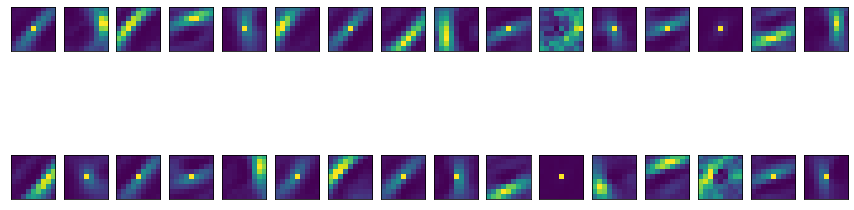

In [73]:
plot_kernels(layer, n_pola, R)

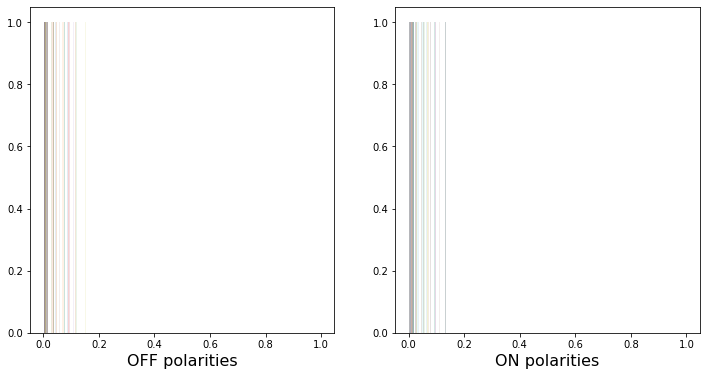

In [75]:
plot_weight_distribution(layer)

In [72]:
import numpy as np
def plot_kernels(layer, pola, R):
    fig = plt.figure(figsize=(15,5))
    kernel = layer.synapses.weight.data.T
    for n in range(len(kernel[0,:])):
        for p in range(pola):
            sub = fig.add_subplot(pola,len(kernel[0,:]),n+len(kernel[0,:])*p+1)
            dico = np.reshape(kernel[p*(2*R+1)**2:(p+1)*(2*R+1)**2,n], [int(np.sqrt(len(kernel)/pola)), int(np.sqrt(len(kernel)/pola))])
            sub.imshow((dico))
            sub.axes.get_xaxis().set_visible(False)
            sub.axes.get_yaxis().set_visible(False)
    plt.show()
    
def plot_weight_distribution(layer, bins=np.linspace(0, 1, 50)):
    kernels = layer.synapses.weight.data
    fig, axs = plt.subplots(1,2, figsize=(12, 6))
    n_neurons = kernels.size(dim=0)
    ts_size = int(kernels.size(dim=1)/2)
    for k in range (n_neurons):
        pos_kernels = kernels[k][ts_size:]
        neg_kernels = kernels[k][:ts_size]
        axs[0].hist(neg_kernels, bins=bins, alpha=.1)
        axs[0].set_xlabel('OFF polarities', fontsize=16)
        axs[1].hist(pos_kernels, bins=bins, alpha=.1)
        axs[1].set_xlabel('ON polarities', fontsize=16)
    plt.show()
    
def plot_loss(df_train):
    fig_width, phi = 15, np.sqrt(5)/2 + 1/2
    fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi/2))
    ax = df_train['loss'].plot(lw=2, marker='.', markersize=10)
    ax.set_xlabel("Epoch", size=18)
    ax.set_ylabel("Loss", size=18)
    ax.spines['left'].set_position(('axes', -0.01))
    ax.grid(which='both')
    for side in ['top', 'right']: ax.spines[side].set_visible(False)
    ax.set_ylim(0.);
    plt.show()